### Homework: going neural (6 pts)

We've checked out statistical approaches to language models in the last notebook. Now let's go find out what deep learning has to offer.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/expanding_mind_lm_kn_3.png' width=300px>

We're gonna use the same dataset as before, except this time we build a language model that's character-level, not word level. Before you go:
* If you haven't done seminar already, use `seminar.ipynb` to download the data.
* This homework uses Pytorch v1.x: this is [how you install it](https://pytorch.org/get-started/locally/); and that's [how you use it](https://github.com/yandexdataschool/Practical_RL/tree/9f89e98d7df7ad47f5d6c85a70a38283e06be16a/week04_%5Brecap%5D_deep_learning).

In [1]:
# code is at the bottom
!wget --no-verbose -O magic.py https://raw.githubusercontent.com/virtualphoton/ds_utils/a4afa200f0e39cfd04bf83783236eb7308cb4304/magic.py
!wget --no-verbose -O plotter.py https://raw.githubusercontent.com/virtualphoton/ds_utils/a4afa200f0e39cfd04bf83783236eb7308cb4304/plotter.py
!wget --no-verbose -O torch_utils.py https://raw.githubusercontent.com/virtualphoton/ds_utils/a4afa200f0e39cfd04bf83783236eb7308cb4304/torch_utils.py
!wget --no-verbose -O train.py https://raw.githubusercontent.com/virtualphoton/ds_utils/a4afa200f0e39cfd04bf83783236eb7308cb4304/train.py
!wget --no-verbose -O utils.py https://github.com/virtualphoton/ds_utils/blob/a4afa200f0e39cfd04bf83783236eb7308cb4304/utils.py

2023-10-14 23:54:11 URL:https://raw.githubusercontent.com/virtualphoton/ds_utils/a4afa200f0e39cfd04bf83783236eb7308cb4304/magic.py [5704/5704] -> "magic.py" [1]
2023-10-14 23:54:12 URL:https://raw.githubusercontent.com/virtualphoton/ds_utils/a4afa200f0e39cfd04bf83783236eb7308cb4304/plotter.py [6257/6257] -> "plotter.py" [1]
2023-10-14 23:54:12 URL:https://raw.githubusercontent.com/virtualphoton/ds_utils/a4afa200f0e39cfd04bf83783236eb7308cb4304/torch_utils.py [1639/1639] -> "torch_utils.py" [1]
2023-10-14 23:54:13 URL:https://raw.githubusercontent.com/virtualphoton/ds_utils/a4afa200f0e39cfd04bf83783236eb7308cb4304/train.py [7250/7250] -> "train.py" [1]
2023-10-14 23:54:14 URL:https://github.com/virtualphoton/ds_utils/blob/a4afa200f0e39cfd04bf83783236eb7308cb4304/utils.py [7196/7196] -> "utils.py" [1]


In [2]:
from utils import map
from plotter import History, Plotter
from torch_utils import device_default, map_idx, Apply
from magic import reprint, get_outputs
from train import EarlyStopper, State, loopa

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

Working on character level means that we don't need to deal with large vocabulary or missing words. Heck, we can even keep uppercase words in text! The downside, however, is that all our sequences just got a lot longer.

However, we still need special tokens:
* Begin Of Sequence  (__BOS__) - this token is at the start of each sequence. We use it so that we always have non-empty input to our neural network. $P(x_t) = P(x_1 | BOS)$
* End Of Sequence (__EOS__) - you guess it... this token is at the end of each sequence. The catch is that it should __not__ occur anywhere else except at the very end. If our model produces this token, the sequence is over.


In [4]:
BOS, EOS = ' ', '\n'

data = pd.read_json("./arxivData.json")
lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:512], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()

# if you missed the seminar, download data here - https://yadi.sk/d/_nGyU2IajjR9-w

Our next step is __building char-level vocabulary__. Put simply, you need to assemble a list of all unique tokens in the dataset.

In [5]:
# get all unique characters from lines (including capital letters and symbols)
tokens = list(set().union(*lines))

tokens = sorted(tokens)
n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)
assert 100 < n_tokens < 150
assert BOS in tokens, EOS in tokens

n_tokens =  136


We can now assign each character with it's index in tokens list. This way we can encode a string into a torch-friendly integer vector.

In [6]:
# dictionary of character -> its identifier (index in tokens list)
token_to_id = map_idx(tokens)

In [7]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


Our final step is to assemble several strings in a integet matrix `[batch_size, text_length]`. 

The only problem is that each sequence has a different length. We can work around that by padding short sequences with extra _EOS_ or cropping long sequences. Here's how it works:

In [8]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype=np.int64):
    """Casts a list of lines into torch-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.full([len(lines), max_len], pad, dtype=dtype)
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

In [9]:
#Example: cast 4 random names to matrices, pad with zeros
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
print(to_matrix(dummy_lines))



[[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]


### Neural Language Model (2 points including training)

Just like for N-gram LMs, we want to estimate probability of text as a joint probability of tokens (symbols this time).

$$P(X) = \prod_t P(x_t \mid x_0, \dots, x_{t-1}).$$ 

Instead of counting all possible statistics, we want to train a neural network with parameters $\theta$ that estimates the conditional probabilities:

$$ P(x_t \mid x_0, \dots, x_{t-1}) \approx p(x_t \mid x_0, \dots, x_{t-1}, \theta) $$


But before we optimize, we need to define our neural network. Let's start with a fixed-window (aka convolutional) architecture:

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/fixed_window_lm.jpg' width=400px>


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
class FixedWindowLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=64):
        """ 
        A fixed window model that looks on at least 5 previous symbols.
        
        Note: fixed window LM is effectively performing a convolution over a sequence of words.
        This convolution only looks on current and previous words.
        Such convolution can be represented as a sequence of 2 operations:
        - pad input vectors by {strides * (filter_size - 1)} zero vectors on the "left", do not pad right
        - perform regular convolution with {filter_size} and {strides}
        
        - If you're absolutely lost, here's a hint: use nn.ZeroPad2d((NUM_LEADING_ZEROS, 0, 0, 0))
          followed by a nn.Conv1d(..., padding=0). And yes, its okay that padding is technically "2d".
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.
        
        self._emb_size = emb_size
        self._hid_size = hid_size
        self._filter_size = 5
        self._stride = 1
        self._hid2 = 256
        
        self.embedding = nn.Sequential(
            nn.ZeroPad2d((self._stride * (self._filter_size - 1), 0, 0, 0)),
            nn.Embedding(n_tokens, emb_size)
        )
        self.const_window_layer = nn.Sequential(
            Apply(torch.permute, (0, 2, 1)),
            nn.Conv1d(emb_size, hid_size, self._filter_size),
            Apply(torch.permute, (0, 2, 1)),
        )
        self.mlp = nn.Sequential(
            nn.Linear(hid_size, self._hid2),
            nn.ReLU(),
            nn.Dropout1d(.3),
            Apply(torch.permute, (0, 2, 1)),
            nn.BatchNorm1d(self._hid2),
            Apply(torch.permute, (0, 2, 1)),
            nn.Linear(self._hid2, n_tokens)
        )
        
        self.layers = nn.Sequential(self.embedding, self.const_window_layer, self.mlp)
    
    def forward(self, X):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
            
        :note: that convolutions operate with tensors of shape [batch, channels, length], while linear layers
         and *embeddings* use [batch, length, channels] tensors. Use tensor.permute(...) to adjust shapes.
         
        # output tensor should be of shape [batch_size, sequence_length, n_tokens]
        """
        return self.layers(X)
    
    @device_default
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100, *, device):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        device
        
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64, device=device)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))
        

In [12]:
dummy_model = FixedWindowLanguageModel()
dummy_model.eval()

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = dummy_model(dummy_input_ix)

print('Weights:', tuple(name for name, _ in dummy_model.named_parameters()))

Weights: ('embedding.1.weight', 'const_window_layer.1.weight', 'const_window_layer.1.bias', 'mlp.0.weight', 'mlp.0.bias', 'mlp.4.weight', 'mlp.4.bias', 'mlp.6.weight', 'mlp.6.bias')


In [13]:
assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits.data.cpu().numpy())), "inf/nan encountered"
assert not np.allclose(dummy_logits.data.cpu().numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

In [14]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = dummy_model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

We can now tune our network's parameters to minimize categorical crossentropy over training dataset $D$:

$$ L = {\frac1{|D|}} \sum_{X \in D} \sum_{x_i \in X} - \log p(x_t \mid x_1, \dots, x_{t-1}, \theta) $$

As usual with with neural nets, this optimization is performed via stochastic gradient descent with backprop.

One can also note that minimizing crossentropy is equivalent to
minimizing model __perplexity__, KL-divergence or maximizng log-likelihood.

In [15]:
def compute_mask(input_ix, eos_ix=token_to_id[EOS]):
    """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
    return F.pad(torch.cumsum(input_ix == eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)

print('matrix:\n', dummy_input_ix.numpy())
print('mask:', compute_mask(dummy_input_ix).to(torch.int32).cpu().numpy())
print('lengths:', compute_mask(dummy_input_ix).sum(-1).cpu().numpy())

matrix:
 [[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]
mask: [[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
lengths: [ 5  9 15]


In [16]:
@device_default
def compute_loss(model, input_ix, *, device):
    """
    :param model: language model that can compute next token logits given token indices
    :param input ix: int32 matrix of tokens, shape: [batch_size, length]; padded with eos_ix
    :returns: scalar loss function, mean crossentropy over non-eos tokens
    """
    input_ix = torch.as_tensor(input_ix, dtype=torch.int64, device=device)
    

    logits = model(input_ix[:, :-1])
    reference_answers = input_ix[:, 1:]

    # Your task: implement loss function as per formula above
    # your loss should only be computed on actual tokens, excluding padding
    # predicting actual tokens and first EOS do count. Subsequent EOS-es don't
    # you may or may not want to use the compute_mask function from above.
    
    logs = nn.CrossEntropyLoss(reduction='none')(torch.permute(logits, (0, 2, 1)), reference_answers)
    return (logs * compute_mask(input_ix)[:, 1:]).sum(axis=1).mean()
    

In [17]:

loss_1 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=15), device="cpu")
loss_2 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=16), device="cpu")
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"
assert torch.allclose(loss_1, loss_2), 'do not include  AFTER first EOS into loss. '\
    'Hint: use compute_mask. Beware +/-1 errors. And be careful when averaging!'

### Evaluation

You will need two functions: one to compute test loss and another to generate samples. For your convenience, we implemented them both in your stead.

In [18]:
@device_default
def score_lines(model, dev_lines, batch_size, *, device):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    with torch.no_grad():
        for i in range(0, len(dev_lines), batch_size):
            batch_ix = to_matrix(dev_lines[i: i + batch_size])
            dev_loss_num += compute_loss(model, batch_ix, device=device).item() * len(batch_ix)
            dev_loss_len += len(batch_ix)
    return {"loss": dev_loss_num / dev_loss_len}

def generate(model, prefix=BOS, temperature=1.0, max_len=100):
    """
    Samples output sequence from probability distribution obtained by model
    :param temperature: samples proportionally to model probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    model.eval()
    with torch.no_grad():
        while True:
            token_probs = model.get_possible_next_tokens(prefix)
            tokens, probs = zip(*token_probs.items())
            if temperature == 0:
                next_token = tokens[np.argmax(probs)]
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                next_token = np.random.choice(tokens, p=probs)

            prefix += next_token
            if next_token == EOS or len(prefix) > max_len: break
    model.train()
    return prefix

### Training loop

Finally, let's train our model on minibatches of data

In [19]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 256
score_dev_every = 250
history = History()
model = FixedWindowLanguageModel().to(device)
opt = torch.optim.Adam(model.parameters())

train_history, dev_history = [], []

# hint: if you ever wanted to switch to cuda, do it now.


# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
history.push_epoch(dev_history[0][1])
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: Bridging



In [20]:
%%reprint

from random import sample

plotter_fixedwin = Plotter(bound_history=history, path="storage/fix_win.png")
plotter = plotter_fixedwin
stopper = EarlyStopper(state=State(model, opt, history, "storage/fix_win.pth"),
                       patience=3)
model.train()

for i in history.range(5000, stopper, do_tqdm=True):
    batch = to_matrix(sample(train_lines, batch_size))
    
    loss_i = compute_loss(model, batch)
    
    opt.zero_grad()
    loss_i.backward()
    opt.step()
    train_history.append((i, loss_i.item()))
    history.push_epoch({"loss": loss_i.item()}, {})
    
    if (i + 1) % score_dev_every == 0:
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        history.val[-1] = dev_history[-1][1]
        
    if (i + 1) % 50 == 0:
        plotter.plot()
        
        print("Generated examples (tau=0.5):")
        print("\n".join(generate(model, temperature=0.5) for _ in range(3)))


/home/photon/PyProjects/nlp_course/week03_lm/ds_utils/plotter.py:76: UserWarning: File already exists!
  warnings.warn("File already exists!")
/home/photon/PyProjects/nlp_course/week03_lm/ds_utils/train.py:124: UserWarning: Saver: storage/fix_win.pth already exists!
  warn(f"Saver: {self.path} already exists!")


epoch:   0%|          | 0/4999 [00:00<?, ?it/s]

FigureWidget({
    'data': [],
    'layout': {'annotations': [{'font': {'size': 16},
                                'showarrow': False,
                                'text': 'loss',
                                'x': 0.5,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'}],
               'height': 600,
               'showlegend': True,
               'template': '...',
               'width': 1000,
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0]},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0]}}
})

MyOutput()

MyOutput()

In [21]:
out_fixedwin = get_outputs()

<a id="1_src" href="#1_dest">to static output</a>

In [25]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])

for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: {'loss': 935.5722286823552}
 Detection in topically contential exames are computation situations residual ensider algorithm anali
 A structured from deep selected to a new to a mather the an emerge in this paper we exact environmer
 Geomention and local as a novel sele of the process, a gais to the allocation, that it is the state 
 Context analyting of still image the techniques between a words of the action to a deep local intera
 Larget constrained to estimation for More set of the age a novel the solution algorithm a convolutio
 A Correcterid to noisinate segmental state an entor community a set of deep learning the contextabil
 Hor the study and its that it is on algorios of the problem of the compares content change of the lo
 Tereas time an important Hangues in the eascurrent interest a new although it is an energy the proba
 Conselling to the trans an in the comparison the learning and categoriem of the constration and neur
 Senteraction is paper the learning st

### RNN Language Models (3 points including training)

Fixed-size architectures are reasonably good when capturing short-term dependencies, but their design prevents them from capturing any signal outside their window.

We can mitigate this problem by using a __recurrent neural network__:

$$ h_0 = \vec 0 ; \quad h_{t+1} = RNN(x_t, h_t) $$

$$ p(x_t \mid x_0, \dots, x_{t-1}, \theta) = dense_{softmax}(h_{t-1}) $$

Such model processes one token at a time, left to right, and maintains a hidden state vector between them. Theoretically, it can learn arbitrarily long temporal dependencies given large enough hidden size.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/rnn_lm.jpg' width=480px>

In [20]:
class RNNLanguageModel(nn.Module):
    def __init__(self, n_tokens, emb_size=16, hid_size=256):
        """ 
        Build a recurrent language model.
        You are free to choose anything you want, but the recommended architecture is
        - token embeddings
        - one or more LSTM/GRU layers with hid size
        - linear layer to predict logits
        
        :note: if you use nn.RNN/GRU/LSTM, make sure you specify batch_first=True
         With batch_first, your model operates with tensors of shape [batch_size, sequence_length, num_units]
         Also, please read the docs carefully: they don't just return what you want them to return :)
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.
        
        self._lstm_layers = 3
        self._hid2 = 256
        
        self.emb = nn.Embedding(n_tokens, emb_size)
        self.rnn = nn.GRU(emb_size, hid_size, num_layers=self._lstm_layers, batch_first=True)
        self.mlp = nn.Sequential(
            nn.Linear(hid_size, self._hid2),
            nn.ReLU(),
            nn.Dropout1d(.3),
            Apply(torch.permute, (0, 2, 1)),
            nn.BatchNorm1d(self._hid2),
            Apply(torch.permute, (0, 2, 1)),
            nn.Linear(self._hid2, n_tokens)
        )
    
    def forward(self, X):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        X = self.emb(X)
        X = self.rnn(X)[0]
        X = self.mlp(X)
        return X
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64, device=device)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))
        

In [21]:
model = RNNLanguageModel(n_tokens)
model.eval()

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = model(dummy_input_ix)

assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert not np.allclose(dummy_logits.cpu().data.numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"
print('Weights:', tuple(name for name, w in model.named_parameters()))

Weights: ('emb.weight', 'rnn.weight_ih_l0', 'rnn.weight_hh_l0', 'rnn.bias_ih_l0', 'rnn.bias_hh_l0', 'rnn.weight_ih_l1', 'rnn.weight_hh_l1', 'rnn.bias_ih_l1', 'rnn.bias_hh_l1', 'rnn.weight_ih_l2', 'rnn.weight_hh_l2', 'rnn.bias_ih_l2', 'rnn.bias_hh_l2', 'mlp.0.weight', 'mlp.0.bias', 'mlp.4.weight', 'mlp.4.bias', 'mlp.6.weight', 'mlp.6.bias')


In [22]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

### RNN training

Our RNN language model should optimize the same loss function as fixed-window model. But there's a catch. Since RNN recurrently multiplies gradients through many time-steps, gradient values may explode, [ruining](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/nan.jpg) your model.
The common solution to that problem is to clip gradients either [individually](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_value) or [globally](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_global_norm).

Your task here is to implement the training code that minimizes the loss function. If you encounter large loss fluctuations during training, please add [gradient clipping](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html) using urls above. But its **not necessary** to use gradient clipping if you don't need it.

_Note: gradient clipping is not exclusive to RNNs. Convolutional networks with enough depth often suffer from the same issue._

In [23]:
batch_size = 255
score_dev_every = 250
train_history, dev_history = [], []
history = History()

model = RNNLanguageModel(n_tokens).to(device)
opt = torch.optim.Adam(model.parameters(), lr=5e-4)

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size, device=device)))
stopper = EarlyStopper(state=State(model, opt, history, "storage/rnn.pth"),
                       patience=3)
history.push_epoch(dev_history[0][1])
print("Sample before training:", generate(model, 'Bridging'))
torch.cuda.empty_cache()

Sample before training: Bridging{&]fD=óőör,|CàtK%8fΠÖwL(W\)`j!+ãl^/gGR1rmŁ7P% z/1_L^àcVíF[ã&NH#Hβêí2śäE]0Ü],8,>$bB?<Ea;15Σ


/home/photon/PyProjects/nlp_course/week03_lm/ds_utils/train.py:124: UserWarning: Saver: storage/rnn.pth already exists!
  warn(f"Saver: {self.path} already exists!")


In [24]:
%%reprint

from random import sample

plotter_rnn = Plotter(bound_history=history, path=stopper.state.path + ".png")
plotter = plotter_rnn
model.train()

for i in history.range(5000, stopper, do_tqdm=True):
    batch = to_matrix(sample(train_lines, batch_size))
    
    loss_i = compute_loss(model, batch)
    
    opt.zero_grad()
    loss_i.backward()
    opt.step()
    train_history.append((i, loss_i.item()))
    history.push_epoch({"loss": loss_i.item()}, {})
    
    if (i + 1) % score_dev_every == 0:
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        history.val[-1] = dev_history[-1][1]
        
    if (i + 1) % 50 == 0:
        plotter.plot()
        
        print("Generated examples (tau=0.5):")
        print("\n".join(generate(model, temperature=0.5) for _ in range(3)))

/home/photon/PyProjects/nlp_course/week03_lm/ds_utils/plotter.py:76: UserWarning: File already exists!
  warnings.warn("File already exists!")


epoch:   0%|          | 0/4999 [00:00<?, ?it/s]

FigureWidget({
    'data': [],
    'layout': {'annotations': [{'font': {'size': 16},
                                'showarrow': False,
                                'text': 'loss',
                                'x': 0.5,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'}],
               'height': 600,
               'showlegend': True,
               'template': '...',
               'width': 1000,
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0]},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0]}}
})

MyOutput()

MyOutput()

In [25]:
out_rnn = get_outputs()

<a id="2_src" href="#2_dest">to static output</a>

In [30]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])
for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: {'loss': 819.856893697599}
 A reinforcement Learning and   Reinforcement Learning of Records Nets   to Product   and   Transitio
 Neural   neural networks ; Contrastive reading process is an important task that encoding an optimis
 Graph discriminative algorithm can be reduced novel approaches to reason sentences are effective in 
 An efficient method for hierarchical release in the Tensor   Inverse Data Sets ; Participant sets of
 Content with   training variable are two state-of-the-art idea is a nonconvexity of regularizer succ
 A Markov random   Segmentation of   and analyzing the   consistent and an Answer Set of Model   Inva
 A nonlinear transformation of the Unert Neural   Network Tree   Completion ; We study the content of
 Faithful in Scaling Feedback   Translation   for Distributive   Learning ; We consider the online se
 Learning to the Uniform Margin Search Algorithm for   Adaptive Detection of a   Mela   Color   Selec
 Deep   Analysis of Discrete Constraint

### Alternative sampling strategies (1 point)

So far we've sampled tokens from the model in proportion with their probability.
However, this approach can sometimes generate nonsense words due to the fact that softmax probabilities of these words are never exactly zero. This issue can be somewhat mitigated with sampling temperature, but low temperature harms sampling diversity. Can we remove the nonsense words without sacrificing diversity? __Yes, we can!__ But it takes a different sampling strategy.

__Top-k sampling:__ on each step, sample the next token from __k most likely__ candidates from the language model.

Suppose $k=3$ and the token probabilities are $p=[0.1, 0.35, 0.05, 0.2, 0.3]$. You first need to select $k$ most likely words and set the probability of the rest to zero: $\hat p=[0.0, 0.35, 0.0, 0.2, 0.3]$ and re-normalize: 
$p^*\approx[0.0, 0.412, 0.0, 0.235, 0.353]$.

__Nucleus sampling:__ similar to top-k sampling, but this time we select $k$ dynamically. In nucleous sampling, we sample from top-__N%__ fraction of the probability mass.

Using the same  $p=[0.1, 0.35, 0.05, 0.2, 0.3]$ and nucleous N=0.9, the nucleous words consist of:
1. most likely token $w_2$, because $p(w_2) < N$
2. second most likely token $w_5$, $p(w_2) + p(w_5) = 0.65 < N$
3. third most likely token $w_4$ because $p(w_2) + p(w_5) + p(w_4) = 0.85 < N$

And thats it, because the next most likely word would overflow: $p(w_2) + p(w_5) + p(w_4) + p(w_1) = 0.95 > N$.

After you've selected the nucleous words, you need to re-normalize them as in top-k sampling and generate the next token.

__Your task__ is to implement nucleus sampling variant and see if its any good.

In [31]:
def generate_nucleus(model, prefix=BOS, nucleus=0.9, max_len=100):
    """
    Generate a sequence with nucleous sampling
    :param prefix: a string containing space-separated previous tokens
    :param nucleus: N from the formulae above, N \in [0, 1]
    :param max_len: generate sequences with at most this many tokens, including prefix
    
    :note: make sure that nucleous always contains at least one word, even if p(w*) > nucleus
    
    """
    model.eval()
    while True:
        token_probs = model.get_possible_next_tokens(prefix)
        tokens, probs = map(np.array, zip(*token_probs.items()))
        
        indices = probs.argsort()[::-1]
        mask = probs[indices].cumsum() < nucleus
        mask[0] = True
        
        probs = probs[indices[mask]]
        next_token = np.random.choice(tokens[indices[mask]], p=probs / probs.sum())
        
        prefix += next_token
        if next_token == EOS or len(prefix) > max_len: break
    model.train()
    return prefix

In [32]:
for i in range(10):
    print(generate_nucleus(model, nucleus=.7))

 Single Translation   control of structure in image processing of residual for interesting and propos
 Deep   Reconstruction of Neural Networks ; We consider simple information as a special in computer s
 Person Projection in Dense Prediction ; This submission approach is an essential training technique 
 Estimating Adaptive   Sensor   Model control in a fully detect and test the use of such a method of 
 Detecting the   classification for representing the decoder of   semantic transformations in the inf
 Protein Time of Attention and Convergence on Internet   in the Curriculus Active Classification of C
 A Scalable Corpus of   Sparse and Reconstruction for   Online Transfer and Statistical   and Region 
 A Neural Network with a Semantic Similarity of the Dialogue ; The aim of the optimization approach a
 Person   to estimate a logic model of the computational properties of interest proposed methods allo
 End-to-End Reconstruction of a Computational   Structure to Partial Distributed  

### Bonus quest I: Beam Search (2 pts incl. samples)

At times, you don't really want the model to generate diverse outputs as much as you want a __single most likely hypothesis.__ A single best translation, most likely continuation of the search query given prefix, etc. Except, you can't get it. 

In order to find the exact most likely sequence containing 10 tokens, you would need to enumerate all $|V|^{10}$ possible hypotheses. In practice, 9 times out of 10 you will instead find an approximate most likely output using __beam search__.

Here's how it works:
0. Initial `beam` = [prefix], max beam_size = k
1. for T steps:
2. ` ... ` generate all possible next tokens for all hypotheses in beam, formulate `len(beam) * len(vocab)` candidates
3. ` ... ` select beam_size best for all candidates as new `beam`
4. Select best hypothesis (-es?) from beam

In [33]:
from IPython.display import HTML
# Here's what it looks like:
!wget -q https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/resources/beam_search.html
HTML("beam_search.html")

In [35]:
def generate_beamsearch(model, prefix=BOS, beam_size=4, length=5):
    model.eval()
    
    beam = [prefix]
    for _ in range(length):
        new_seqs = {(seq, token) : proba
                    for seq in beam
                    for token, proba in model.get_possible_next_tokens(seq).items()
                    if seq[-1] != EOS}
        beam = sorted(new_seqs, key=new_seqs.get, reverse=True)[:beam_size]
        beam = [seq + token for seq, token in beam]
        
    model.train()
    return beam
    

In [36]:
generate_beamsearch(model, prefix=' deep ', beam_size=4, length=10)

[' deep convolutio',
 ' deep reinforcem',
 ' deep neural net',
 ' deep learning a']

In [59]:
# check it out: which beam size works best?
# find at least 5 prefixes where beam_size=1 and 8 generates different sequences

In [38]:
for i in range(1, 6):
    prefix = "!" * i

    beam_8 = generate_beamsearch(model, prefix=prefix, beam_size=8, length=2)
    beam_1 = generate_beamsearch(model, prefix=prefix, beam_size=1, length=2)
    assert beam_1[0] not in beam_8
    print(f"{prefix=}:\n{beam_1=}\n{beam_8=}\n")

prefix='!':
beam_1=['! a']
beam_8=['!in', '!de', '!ne', '!co', '!he', '!ho', '!ch', '!an']

prefix='!!':
beam_1=['!! a']
beam_8=['!!, ', '!!de', '!!he', '!!ec', '!!in', '!!hi', '!!k ', '!!is']

prefix='!!!':
beam_1=['!!! a']
beam_8=['!!!, ', '!!!de', '!!!hi', '!!!k ', '!!!in', '!!!he', '!!!ec', '!!!is']

prefix='!!!!':
beam_1=['!!!! a']
beam_8=['!!!!de', '!!!!hi', '!!!!k ', '!!!!ch', '!!!!in', '!!!!co', '!!!!di', '!!!!h ']

prefix='!!!!!':
beam_1=['!!!!! a']
beam_8=['!!!!!: ', '!!!!!de', '!!!!!hi', '!!!!!ch', '!!!!!co', '!!!!!h ', '!!!!!in', '!!!!!ca']



## Bonus quest II: Ultimate Language Model (2+ pts)

So you've learned the building blocks of neural language models, you can now build the ultimate monster:  
* Make it char-level, word level or maybe use sub-word units like [bpe](https://github.com/rsennrich/subword-nmt);
* Combine convolutions, recurrent cells, pre-trained embeddings and all the black magic deep learning has to offer;
  * Use strides to get larger window size quickly. Here's a [scheme](https://storage.googleapis.com/deepmind-live-cms/documents/BlogPost-Fig2-Anim-160908-r01.gif) from google wavenet.
* Train on large data. Like... really large. Try [1 Billion Words](http://www.statmt.org/lm-benchmark/1-billion-word-language-modeling-benchmark-r13output.tar.gz) benchmark;
* Use training schedules to speed up training. Start with small length and increase over time; Take a look at [one cycle](https://medium.com/@nachiket.tanksale/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for learning rate;

_You are NOT required to submit this assignment. Please make sure you don't miss your deadline because of it :)_

### Eigenvoid (bpe)

"Eigenvoid" was a word generated only once as the output of this model.

`generate(model, prefix="The concept of Eigenvoid")`:

The concept of Eigenvoid Hidden Materia ; In this work we formulate the framework of DNNs fov problem efficiently sulggregated stages using only organized relationships. Query can gain lexical and negative efficiency forms then utilize a semantic set up to the

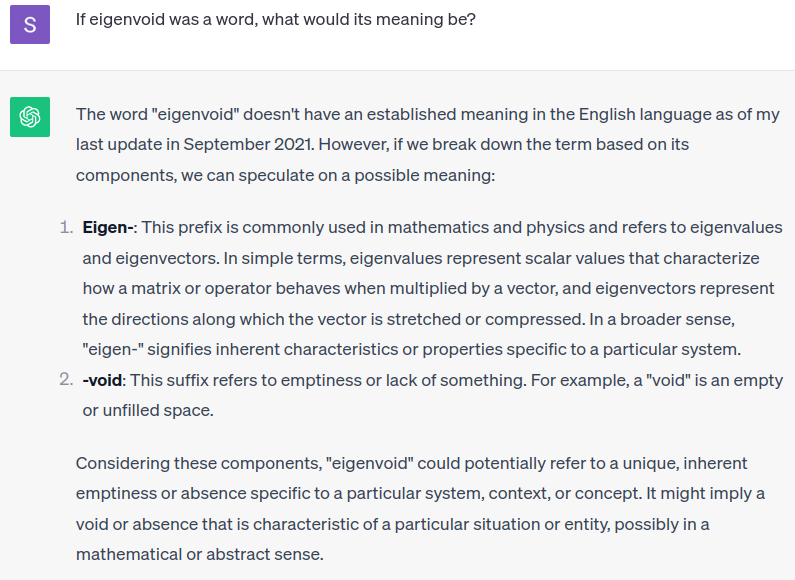

Why did I include this? Because I find beautiful both this word and (especially) the definition given by chatGPT.

In [32]:
!pip install --quiet subword-nmt

In [39]:
import os
from contextlib import contextmanager
from io import StringIO
from random import randint
from subword_nmt.apply_bpe import BPE


from sklearn.model_selection import train_test_split
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

In [40]:
train_lines, val_lines = train_test_split(lines, test_size=0.25, random_state=42)

Default dropout proba is taken from a [paper](https://arxiv.org/abs/1910.13267), written by some unknown fox.

In [41]:
def train_bpe(inp_str, num_symbols):
    codes = StringIO()
    learn_bpe(StringIO(inp_str),
            codes,
            num_symbols)
    return codes

@contextmanager
def temp_file(string):
    path = f"storage/_temp_{randint(0, 10**10)}.txt"
    with open(path, "w") as f:
        print(string, file=f)
    try:
        yield path
    finally:
        os.remove(path)

def into_bpes(string, bpe: BPE, dropout=0.1, num_workers=1):
    out = StringIO()
    with temp_file(string) as inp:
        bpe.process_lines(inp, out, dropout, num_workers)
    out.seek(0)
    ret = out.readlines()
    # last sentence is "\n"
    ret.pop()
    return ret

In [42]:
config = train_bpe("".join(train_lines), num_symbols=1000)
bpe = BPE(config)

train_in_bpe = into_bpes("".join(train_lines), bpe, dropout=0, num_workers=12)
token_to_id = map_idx(set("".join(train_in_bpe).split()))

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 326.82it/s]


In [43]:
UNK = "<UNK>"

token_to_id[EOS] = EOS_ix = len(token_to_id)
token_to_id[BOS] = BOS_ix = len(token_to_id)
token_to_id[UNK] = UNK_ix = len(token_to_id)
token_to_id[UNK + "@@"] = len(token_to_id)

In [44]:
def collate_fn(lines, UNK_ix=UNK_ix, EOS_ix=EOS_ix, BOS_ix=BOS_ix, dropout=0):
    bpes = into_bpes("".join(lines), bpe, dropout=dropout, num_workers=1)
    tokens = []
    for line in bpes:
        tokens.append([BOS_ix])
        tokens[-1].extend([token_to_id.get(token, UNK_ix + token.endswith("@@"))
                           for token in line.split()])
        tokens[-1].append(EOS_ix)
        tokens[-1] = torch.tensor(tokens[-1])
    concatenated = nn.utils.rnn.pad_sequence(tokens, batch_first=True, padding_value=EOS_ix)
    return concatenated[:, :-1], concatenated[:, 1:]

In [45]:
from torch.utils.data import DataLoader
from functools import partial   

bprm = dict(batch_size=256, num_workers=12)
train_loader = DataLoader(train_lines, shuffle=True, collate_fn=partial(collate_fn, dropout=.1), **bprm)
val_loader = DataLoader(val_lines, shuffle=False, collate_fn=collate_fn, **bprm)

In [46]:
def compute_mask(input_ix, eos_ix):
    return F.pad(torch.cumsum(input_ix == eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)

def compute_loss(y_pred, y_true, eos_ix):
    logits = torch.permute(y_pred, (0, 2, 1))
    logs = nn.CrossEntropyLoss(reduction='none')(logits, y_true)
    return (logs * compute_mask(y_true, eos_ix=eos_ix)).sum(axis=1).mean()

In [47]:
device = "cuda"

In [ ]:
len(token_to_id)

In this model I've increased embedding size from 16 to 64 and hidden layer neurons in mlp to 1024.

In [48]:
class RNNLanguageModel(nn.Module):
    def __init__(self, n_tokens, emb_size=64, hid_size=256, mlp_hid=1024):
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.
        
        self._lstm_layers = 3
        self._hid2 = mlp_hid
        
        self.emb = nn.Embedding(n_tokens, emb_size)
        self.rnn = nn.GRU(emb_size, hid_size, num_layers=self._lstm_layers, batch_first=True)
        self.mlp = nn.Sequential(
            nn.Linear(hid_size, self._hid2, bias=False),
            Apply(torch.permute, (0, 2, 1)),
            nn.BatchNorm1d(self._hid2),
            Apply(torch.permute, (0, 2, 1)),
            nn.ReLU(),
            nn.Linear(self._hid2, n_tokens)
        )
    
    def forward(self, X):
        X = self.emb(X)
        X = self.rnn(X)[0]
        X = self.mlp(X)
        return X
    
    def get_possible_next_tokens(self, prefix_ix):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return probs
        

In [49]:
def generate(model, prefix=BOS, temperature=1.0, max_len=100):
    prefix_ix = collate_fn([prefix + "\n"], UNK_ix, EOS_ix, BOS_ix)[0].to(device)
    model.eval()
    with torch.no_grad():
        while True:
            probs = model.get_possible_next_tokens(prefix_ix)
            if temperature == 0:
                next_token = np.argmax(probs)
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                next_token = np.random.choice(len(probs), p=probs)
            prefix_ix = torch.hstack([prefix_ix, torch.tensor([[next_token]], device=device)])
            if next_token == EOS_ix or prefix_ix.shape[1] > max_len: break
    model.train()
    
    tokens = [token[:-2] if token.endswith("@@") else token + " " for token in token_to_id]
    result = "".join(tokens[tok_id] for tok_id in prefix_ix.flatten())
    
    return result

In [50]:
score_dev_every = len(train_lines)
history = History()

model = RNNLanguageModel(n_tokens=len(token_to_id)).to(device)
opt = torch.optim.Adam(model.parameters(), lr=6e-4)

stopper = EarlyStopper(state=State(model, opt, history, "storage/rnn_bpe.pth"),
                       patience=3)

/home/photon/PyProjects/nlp_course/week03_lm/ds_utils/train.py:124: UserWarning:

Saver: storage/rnn_bpe.pth already exists!



In [51]:
%%reprint

torch.cuda.empty_cache()
plotter_rnn_bpe = Plotter(bound_history=history, path="storage/rnn_bpe.png")
plotter = plotter_rnn_bpe

params = dict(
    model=stopper.state.model, optim=stopper.state.optimizer, device=device,
    loss_fn=partial(compute_loss, eos_ix=EOS_ix),
    metrics=["loss"]
)
num_epochs = 40
for _ in history.range(num_epochs, stopper, do_tqdm=True):
    tr = loopa(**params, dataloader=train_loader, is_train=True)
    val = loopa(**params, dataloader=val_loader, is_train=False)
    history.push_epoch(tr, val)
    plotter.plot()
    print("Generated examples (tau=0.5):")
    print("\n".join(generate(model, temperature=0.5) for _ in range(3)))

/home/photon/PyProjects/nlp_course/week03_lm/ds_utils/plotter.py:76: UserWarning:

File already exists!



epoch:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

FigureWidget({
    'data': [],
    'layout': {'annotations': [{'font': {'size': 16},
                                'showarrow': False,
                                'text': 'loss',
                                'x': 0.5,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'}],
               'height': 600,
               'showlegend': True,
               'template': '...',
               'width': 1000,
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0]},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0]}}
})

MyOutput()

MyOutput()

(stop by reaching patience of `EarlyStopper`)

In [53]:
out_rnn_bpe = get_outputs()

<a id="3_src" href="#3_dest">to static output</a>

### Same, but with one-cycle lr scheduler

In [56]:
history = History()

model = RNNLanguageModel(n_tokens=len(token_to_id)).to(device)
opt = torch.optim.Adam(model.parameters(), lr=6e-4)
num_epochs = 40
scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, 1e-2, total_steps=num_epochs)

stopper = EarlyStopper(state=State(model, opt, history, "storage/rnn_bpe_onecycle.pth", scheduler=scheduler),
                       patience=3)

/home/photon/PyProjects/nlp_course/week03_lm/ds_utils/train.py:124: UserWarning:

Saver: storage/rnn_bpe_onecycle.pth already exists!



In [57]:
%%reprint
from ds_utils.train import loopa

model, opt, history, scheduler = stopper.state.as_tuple()
torch.cuda.empty_cache()
plotter_rnn_bpe_onecycle = Plotter(bound_history=history, path="storage/rnn_bpe_onecycle.png")
plotter = plotter_rnn_bpe_onecycle

params = dict(
    model=model, optim=opt, scheduler=scheduler, device=device,
    loss_fn=partial(compute_loss, eos_ix=EOS_ix),
    metrics=["loss"]
)

for _ in history.range(num_epochs, stopper, do_tqdm=True):
    tr = loopa(**params, dataloader=train_loader, is_train=True)
    val = loopa(**params, dataloader=val_loader, is_train=False)
    history.push_epoch(tr, val)
    plotter.plot()
    print("Generated examples (tau=0.5):")
    print("\n".join(generate(model, temperature=0.5) for _ in range(3)))

epoch:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

FigureWidget({
    'data': [],
    'layout': {'annotations': [{'font': {'size': 16},
                                'showarrow': False,
                                'text': 'loss',
                                'x': 0.5,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'}],
               'height': 600,
               'showlegend': True,
               'template': '...',
               'width': 1000,
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0]},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0]}}
})

MyOutput()

MyOutput()

In [59]:
out_rnn_bpe_onecycle = get_outputs()

<a id="4_src" href="#4_dest">to static output</a>

It's pretty evident that OneCycle scheduling is superior to constant lr, reaching loss of $\approx473$ in just 13 epochs (as opposed to 25 epochs) and also allowing model to converge to lower loss.

And, just some fun output after the first epoch:

    Suebasing ; ebabilistic ual of Mon Given (PPES) in the general of the image e of blem of the number of of oved by a novel bases of cortain ationy of the data to the of bases of blem of cervolving e to generod the at of the first stof the performance algof of th

Models with bpe seem to create more reasonable sentences than model built on chars. It was also interesting to observe how the net first understood, where it's appropriate to put acronyms, while also putting comlete nonsense into an acronym to actually creating the correct ones, for both easy cases ("variational autoencoder (VAE)"), and non-obvious ones ("an iterative method of multipliers (ADMM)").

The problem is obviously that losses can't be compared directly, since models differ in number of output classes and, more importantly, have different lengts for the encoded texts.

# Bottom

## static plots

In [27]:
from IPython.display import display
from ds_utils.plotter import plotly_static
from ds_utils.magic import display_no_widgets

<a id="1_dest" href="#1_src">[back]</a>

In [23]:
display_no_widgets(plotter_fixedwin, out_fixedwin)

Generated examples (tau=0.5):

 The polor Convolutional track for bot results of bein the efition analysis in a real ant in to a loc
 Selection problem of the the processing a generation and Reality the must the convent a not roboton 
 Convolution of the can be recently use this more manites and of a solve propose the othesis the mode



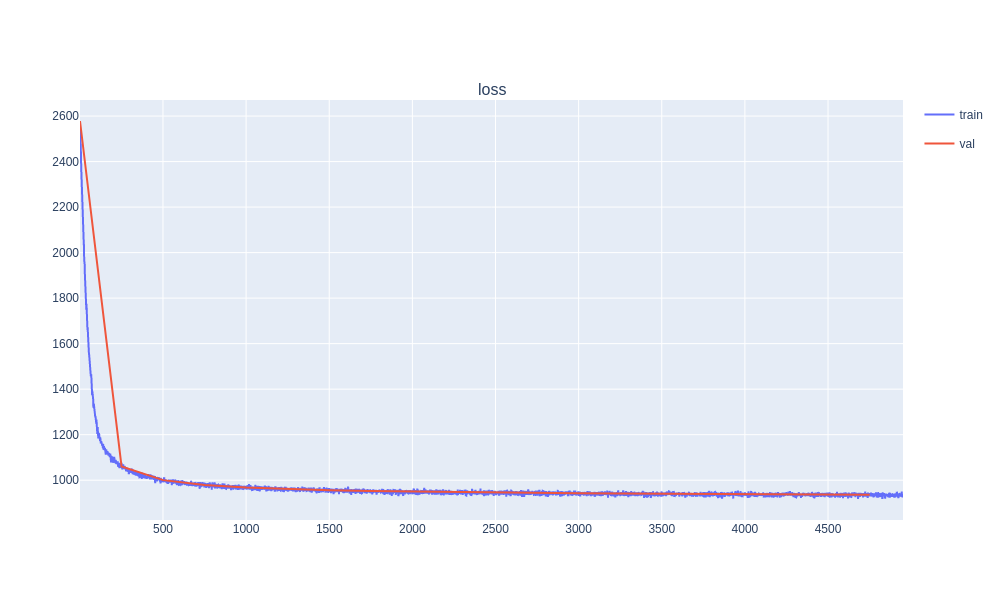

In [24]:
display(plotly_static(plotter_fixedwin.draw_no_widget()))

<a id="2_dest" href="#2_src">[back]</a>

In [28]:
display_no_widgets(plotter_rnn, out_rnn)

Generated examples (tau=0.5):

 Interpretability of Bilinear Decision Mixture of Selection   and Training Samples Detection   Statis
 Heta speed approaches for current empirical evolution of person in a convolutional network for the D
 Reconstruction   Introduction and Deep Convolutional Neural Networks ; The paper describes a novel s



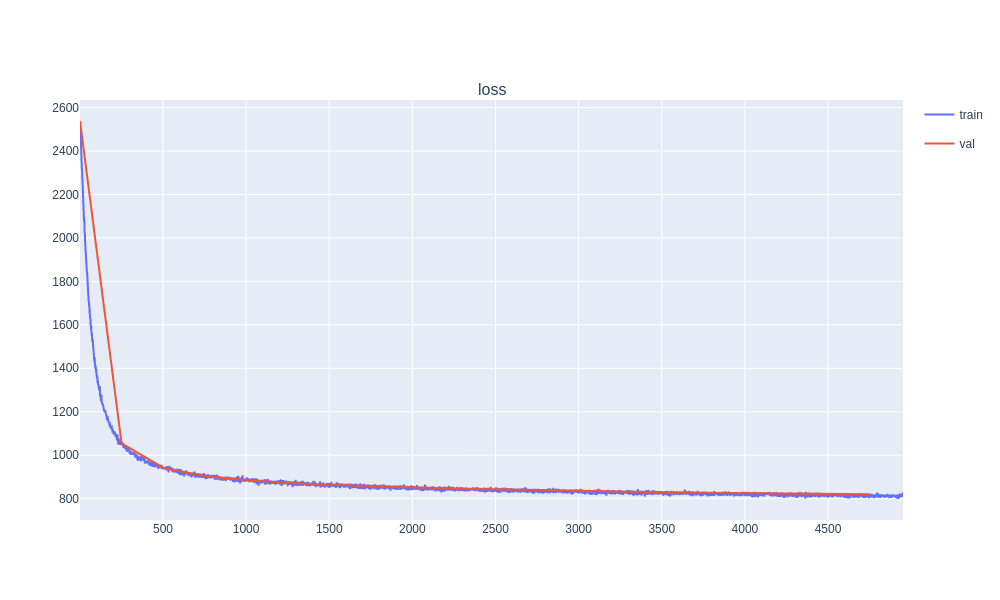

In [29]:
display(plotly_static(plotter_rnn.draw_no_widget()))

<a id="3_dest" href="#3_src">[back]</a> rnn with bpe

In [54]:
display_no_widgets(plotter_rnn_bpe, out_rnn_bpe)

Generated examples (tau=0.5):

  Simultaneously Supervised and Sub-based Decision Making ; In this paper, we address the problem of estimating $\ell_1$ norm, and $k$-means cluster is nonlinear relationship between through the norm. We use the hidden logistic regression model is able to represent an ontological parameter 
  A General Framework for Sentiment Analysis of Hierarchical Reinforcement Learning ; We present a novel approach for learning a multilingual normal variation of the global optimization problem as a family of $k$ points $X$ and $X$ is a nonlinear cost function $X$ with $X$ and $\mathcal{O}(\l
  Fast and Accurate Semantic Segmentation in High Dimensional Space ; The Subspace of Markov Chains (GM) is a very simple and effective for the availability of the second configuration of the candidates (a.k.a. the idea of a set of interest (the from p



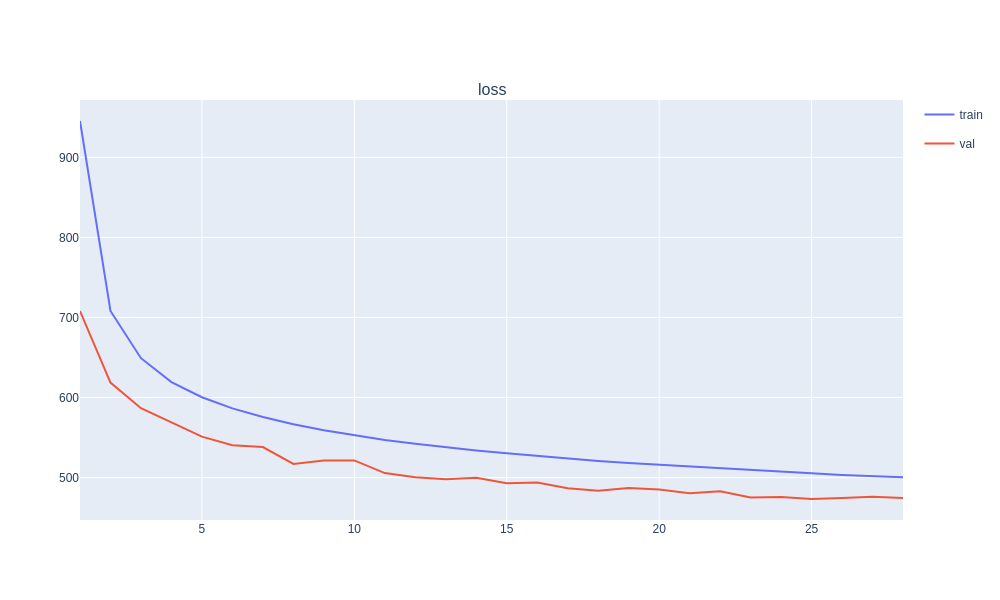

In [55]:
display(plotly_static(plotter_rnn_bpe.draw_no_widget()))

<a id="4_dest" href="#4_src">[back]</a>

(Here the kernel broke down)

Towards Very Large Scale Canonical Correlation Analysis ; We present a method to learn a PCA algorithm to a "mixture of kernel" in a variable while preserving the smooth and independent variables in the measurements of the input, while the maximum likelihood estimator is 

  A Comparison of Deconvolutional Neural Networks for LSTMs ; In this paper, we propose a new method to learn separate information from a large number of videos into a high-dimensional space. This framework is based on a novel variational autoencoder (VAE) framework to extract the input documents into a single object instance. In the proposed method, 
  
  Memory Lasso: A Robust Sparse Bayesian Approach to Subspace Clustering ; We propose a new multilayer neural network for semantic segmentation in the presence of sparse coding and inverse problems. The proposed architecture is applied to the problem of estimating the effect of the cloud and the skill of a product in a 


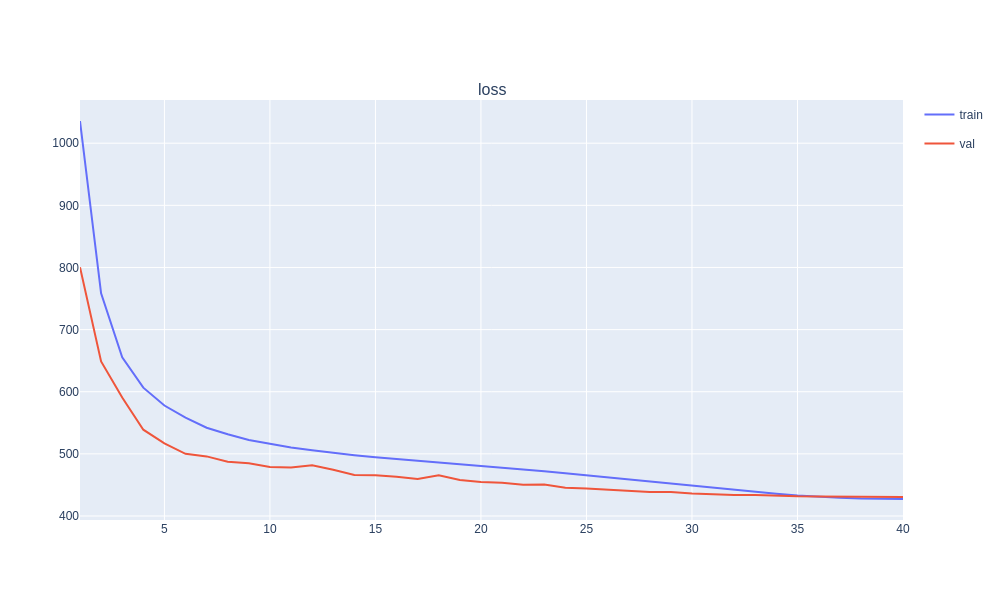

## code

In [64]:
%load magic.py

In [ ]:
%load plotter.py

In [ ]:
%load torch_utils.py

In [ ]:
%load train.py

In [ ]:
%load utils.py